In [110]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import traceback
import numpy as np
import matplotlib
import shapefile
import pygeoif
import snappy
import pandas as pd
import os

from snappy import Product
from snappy import ProductIO
from snappy import ProductUtils
from snappy import WKTReader
from snappy import HashMap
from snappy import GPF
from snappy import jpy
from snappy import GeoPos
from snappy import PixelPos

In [3]:
import skimage.exposure as exposure # Correr dos veces si llega a fallar

In [137]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.display.max_columns = 999

%matplotlib inline

In [5]:
def plot_band(band_data, gray=True):
    val1, val2 = np.percentile(band_data, (2.5,97.5))
    band_data_new = exposure.rescale_intensity(band_data, in_range=(val1,val2))

    plt.figure(figsize=(8, 8))                     
    fig = (
        plt.imshow(band_data_new, cmap = cm.gray)
        if gray else plt.imshow(band_data_new)
    )
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()


def get_band_array(product, band):
    band_data = product.getBand(band)
    width, height = band_data.getRasterWidth(), band_data.getRasterHeight()
    band_data_array = np.zeros(width*height, dtype = np.float32)
    band_data.readPixels(0, 0, width, height, band_data_array)
    band_data_array.shape = height, width

    print(width, height)
    return band_data_array


def get_operator_info(name):

    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(name)

    print('Operator name: %s' % op_spi.getOperatorDescriptor().getName())
    print('Operator alias: %s\n' % op_spi.getOperatorDescriptor().getAlias())

    param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
    for param in param_Desc:
        info = (
            "Name \"%s\": {\n\tAlias: %s,\n\tdtype: %s,\n\tdefault value: %s,\n\tdescription: %s\n}\n" %
            (
                param.getName(), param.getAlias(), param.getDataType().getName(),
                param.getDefaultValue(), param.getDescription()
            )
        )
        print(info)
    #     print(help(param.getDataType())) 

In [6]:
HashMap = snappy.jpy.get_type('java.util.HashMap')
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

---

In [7]:
ls "../../data/raw/sentinel_satellite_images/"

 El volumen de la unidad C es Windows
 El n£mero de serie del volumen es: CAD2-CEC1

 Directorio de C:\Users\camil\codes\tesis\data\raw\sentinel_satellite_images

25/04/2021  05:34 a.ÿm.    <DIR>          .
25/04/2021  05:34 a.ÿm.    <DIR>          ..
24/04/2021  12:34 a.ÿm.    <DIR>          S2A_MSIL1C_20160110T152632_N0201_R025_T18NXM_20160110T153105.SAFE
25/04/2021  06:40 a.ÿm.    <DIR>          S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105.SAFE
               0 archivos              0 bytes
               4 dirs  617.781.841.920 bytes libres


In [8]:
ls "../../data/processed_raw/sentinel_satellite_images/"

 El volumen de la unidad C es Windows
 El n£mero de serie del volumen es: CAD2-CEC1

 Directorio de C:\Users\camil\codes\tesis\data\processed_raw\sentinel_satellite_images

25/04/2021  06:52 p.ÿm.    <DIR>          .
25/04/2021  06:52 p.ÿm.    <DIR>          ..
25/04/2021  06:05 p.ÿm.    <DIR>          S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105.data
25/04/2021  06:02 p.ÿm.        27.632.831 S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105.dim
25/04/2021  05:02 p.ÿm.    <DIR>          S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105.SAFE
25/04/2021  06:50 p.ÿm.         1.066.279 S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_B12.png
25/04/2021  06:53 p.ÿm.         1.340.061 S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_RGB.png
               3 archivos     30.039.171 bytes
               4 dirs  617.781.825.536 bytes libres


---

### Read product

In [9]:
# For shapefiles

path_to_sentinel_data = "../../data/raw/sentinel_satellite_images/S2A_MSIL1C_20160110T152632_N0201_R025_T18NXM_20160110T153105.SAFE"
product = ProductIO.readProduct(path_to_sentinel_data)

In [10]:
print(list(product.getBandNames()))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12']


---
### Atmospheric correction

In [11]:
get_operator_info('Sen2Cor255')

Operator name: Sen2Cor255
Operator alias: Sen2Cor255

Name "targetProductFile": {
	Alias: None,
	dtype: java.io.File,
	default value: None,
	description: Output file
}

Name "postExecuteTemplate": {
	Alias: None,
	dtype: java.io.File,
	default value: Sen2Cor-post-template.vm,
	description: 
}

Name "sceneOnly": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: None,
	description: Scene Only
}

Name "resolution": {
	Alias: None,
	dtype: java.lang.String,
	default value: 60,
	description: None
}

Name "crOnly": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: false,
	description: None
}

Name "useL2AGIPP": {
	Alias: <html><body>L2A_GIPP file<br>(If a file is selected,<br>the parameters below<br>will not be used)</body></html>,
	dtype: java.io.File,
	default value: ,
	description: Use configuration from GIPP file
}

Name "gip25L2A": {
	Alias: None,
	dtype: java.io.File,
	default value: Sen2Cor-gipp-template.xsl,
	description: GIPP parameter file
}

Name "gipL2A": {
	Ali

In [12]:
parameters = HashMap()

parameters.put("resolution", "ALL") # 10, 20, 60
# parameters.put("targetProductFile", "../../data/processed_raw/")
product_atm_corr = GPF.createProduct("Sen2Cor255", parameters, product)

In [14]:
print(list(product_atm_corr.getBandNames()))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'quality_aot', 'quality_wvp', 'quality_cloud_confidence', 'quality_snow_confidence', 'quality_scene_classification', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12']


In [13]:
# filename_out = 'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105.dim'
# ProductIO.writeProduct(product_ac2, filename_out, 'BEAM-DIMAP')

In [17]:
b4_array = get_band_array(product_atm_corr, 'B4')

(10980L, 10980L)


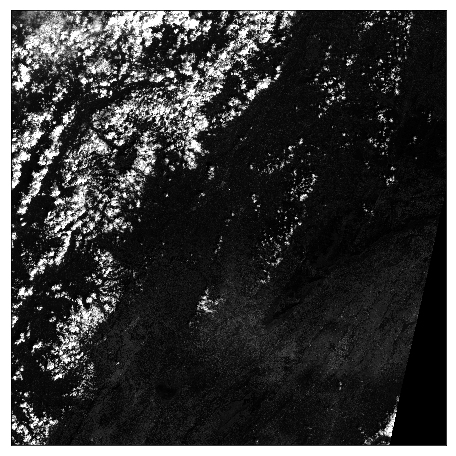

In [18]:
plot_band(b4_array)

---
### Resampling

In [18]:
get_operator_info('Resample')

Operator name: org.esa.snap.core.gpf.common.resample.ResamplingOp
Operator alias: Resample

Name "referenceBandName": {
	Alias: referenceBand,
	dtype: java.lang.String,
	default value: None,
	description: The name of the reference band. All other bands will be re-sampled to match its size and resolution. Either this or targetResolutionor targetWidth and targetHeight must be set.
}

Name "targetWidth": {
	Alias: targetWidth,
	dtype: java.lang.Integer,
	default value: None,
	description: The width that all bands of the target product shall have. If this is set, targetHeight must be set, too. Either this and targetHeight or referenceBand or targetResolution must be set.
}

Name "targetHeight": {
	Alias: targetHeight,
	dtype: java.lang.Integer,
	default value: None,
	description: The height that all bands of the target product shall have. If this is set, targetWidth must be set, too. Either this and targetWidth or referenceBand or targetResolution must be set.
}

Name "targetResolution": {

In [19]:
parameters_resample = HashMap()
target_resolution = 10 # 20, 60
upsampling_method = 'Nearest'
downsampling_method = 'Mean'
parameters_resample.put('downsamplingMethod', downsampling_method)
parameters_resample.put('upsamplingMethod', upsampling_method)
parameters_resample.put('targetResolution', target_resolution)

product_resample = snappy.GPF.createProduct('Resample', parameters_resample, product_atm_corr)

In [20]:
B4 = product_resample.getBand('B4')
B5 = product_resample.getBand('B5')

width_B4, height_B4 = B4.getRasterWidth(), B4.getRasterHeight()
width_B5, height_B5 = B5.getRasterWidth(), B5.getRasterHeight()

print("Band 4 Size: %s, %s" % (width_B4, height_B4))
print("Band 5 Size: %s, %s" % (width_B5, height_B5))

Band 4 Size: 10980, 10980
Band 5 Size: 10980, 10980


In [23]:
b8_array = get_band_array(product_resample, 'B8')

(10980L, 10980L)


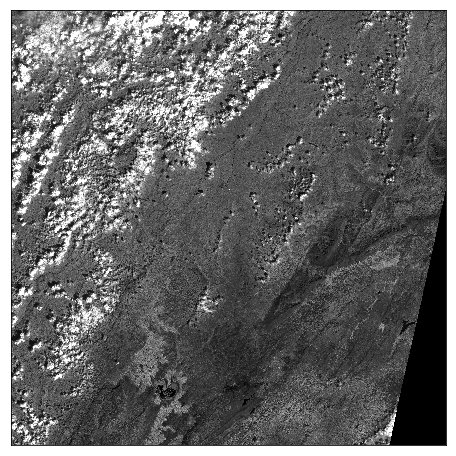

In [24]:
plot_band(b8_array)

---
### Subsetting

In [25]:
get_operator_info('Subset')

Operator name: org.esa.snap.core.gpf.common.SubsetOp
Operator alias: Subset

Name "bandNames": {
	Alias: sourceBands,
	dtype: [Ljava.lang.String;,
	default value: None,
	description: The list of source bands.
}

Name "region": {
	Alias: None,
	dtype: java.awt.Rectangle,
	default value: None,
	description: The subset region in pixel coordinates.
Use the following format: <x>,<y>,<width>,<height>
If not given, the entire scene is used. The 'geoRegion' parameter has precedence over this parameter.
}

Name "referenceBand": {
	Alias: referenceBand,
	dtype: java.lang.String,
	default value: None,
	description: The band used to indicate the pixel coordinates.
}

Name "geoRegion": {
	Alias: None,
	dtype: org.locationtech.jts.geom.Geometry,
	default value: None,
	description: The subset region in geographical coordinates using WKT-format,
e.g. POLYGON((<lon1> <lat1>, <lon2> <lat2>, ..., <lon1> <lat1>))
(make sure to quote the option due to spaces in <geometry>).
If not given, the entire scene i

In [25]:
geometry = WKTReader().read("POLYGON ((-73.7 5.85, -73.3 5.85, -73.3 6.2, -73.7 6.2, -73.7 5.85))")

In [26]:
parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geometry)
product_subset = snappy.GPF.createProduct('Subset', parameters, product_resample)

In [28]:
b6_array = get_band_array(product_subset, 'B6')

(4440L, 3884L)


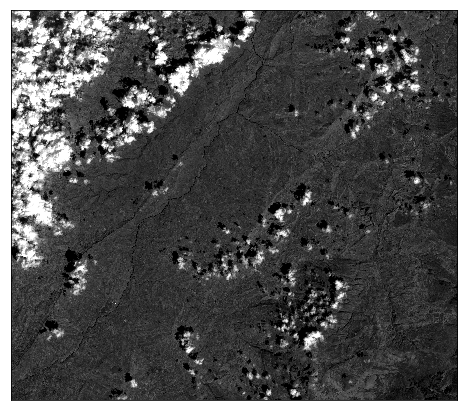

In [29]:
plot_band(b6_array)

---
### Cloud masking, Indices and ratios

In [30]:
get_operator_info('BandMaths')

Operator name: org.esa.snap.core.gpf.common.BandMathsOp
Operator alias: BandMaths

Name "targetBandDescriptors": {
	Alias: targetBands,
	dtype: [Lorg.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor;,
	default value: None,
	description: List of descriptors defining the target bands.
}

Name "variables": {
	Alias: variables,
	dtype: [Lorg.esa.snap.core.gpf.common.BandMathsOp$Variable;,
	default value: None,
	description: List of variables which can be used within the expressions.
}



In [50]:
names = [
    'CloudMask',
    'NDVI',
    'GNDVI',
    'EVI',
    'AVI',
    'SAVI',
    'NDMI',
    'MSI',
    'GCI',
    'NBR',
    'BSI',
    'NDWI',
    'NDSI',
    'ARVI',
    'SIPI'
]
expresions = [
    'if (scl_cloud_medium_proba || scl_cloud_high_proba || scl_thin_cirrus) then 1 else 0',
    '(B8-B4) / (B8+B4)',
    '(B8-B3) / (B8+B3)',
    '2.5*( (B8-B4) / ( (B8 + (6*B4) - (7.5*B2) + 1) ) )',
    'pow( B8 * (1-B4) * (B8-B4), 1/3)',
    '1.428 * ( (B8-B4) / (B8+B4+0.428) )',
    '(B8-B11) / (B8+B11)',
    'B11 / B8',
    '(B9 / B3) - 1',
    '(B8-B12) / (B8+B12)',
    '((B11+B4) - (B8+B2)) / ((B11+B4) + (B8+B2))',
    '(B3-B8) / (B3+B8)',
    '(B3-B11) / (B3+B11)',
    '(B8 - (2*B4) + B2) / (B8 + (2*B4) + B2)',
    '(B8-B2) / (B8+B2)',
]

inds_ = [i for i in range(len(names))]

print(len(names) == len(expresions))

True


In [51]:
paramsCloud = HashMap()

targetBands = jpy.array(
    'org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor',
    len(names)
)
BandDescriptor = jpy.get_type(
    'org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor'
)

for i, name, expresion in zip(inds_, names, expresions):
    targetBand = BandDescriptor()
    targetBand.name = name
    targetBand.type = 'float32'
    targetBand.expression = expresion
    targetBands[i] = targetBand

paramsCloud.put('targetBands', targetBands)
productCloud = GPF.createProduct('BandMaths', paramsCloud, product_subset)

In [52]:
print(list(productCloud.getBandNames()))

['CloudMask', 'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI', 'NDMI', 'MSI', 'GCI', 'NBR', 'BSI', 'NDWI', 'NDSI', 'ARVI', 'SIPI']


(4440L, 3884L)


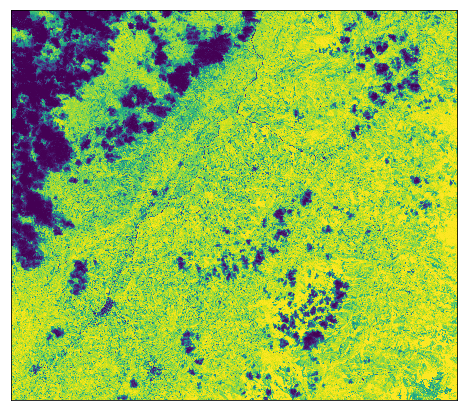

In [78]:
NDVI_array = get_band_array(productCloud, 'NDVI')
plot_band(NDVI_array, False)

(4440L, 3884L)


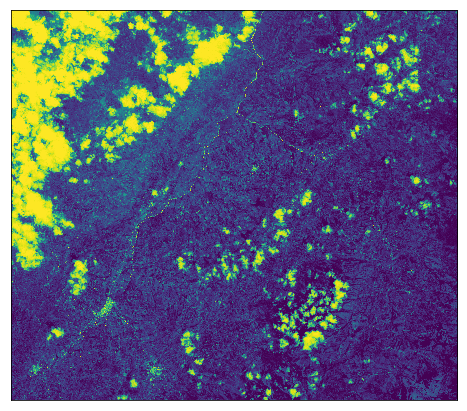

In [79]:
NDWI_array = get_band_array(productCloud, 'NDWI')
plot_band(NDWI_array, False)

(4440L, 3884L)


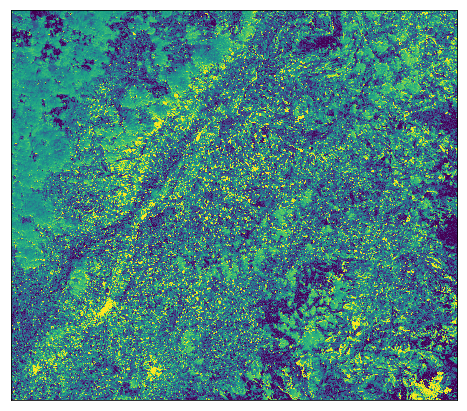

In [80]:
BSI_array = get_band_array(productCloud, 'BSI')
plot_band(BSI_array, False)

---
### Merge products

In [81]:
get_operator_info('Merge')

Operator name: org.esa.snap.core.gpf.common.MergeOp
Operator alias: Merge

Name "includes": {
	Alias: None,
	dtype: [Lorg.esa.snap.core.gpf.common.MergeOp$NodeDescriptor;,
	default value: None,
	description: Defines nodes to be included in the master product. If no includes are provided, all nodes are copied.
}

Name "excludes": {
	Alias: None,
	dtype: [Lorg.esa.snap.core.gpf.common.MergeOp$NodeDescriptor;,
	default value: None,
	description: Defines nodes to be excluded from the target product. Excludes have precedence above includes.
}

Name "geographicError": {
	Alias: None,
	dtype: float,
	default value: 1.0E-5f,
	description: Defines the maximum lat/lon error in degree between the products. If set to NaN no check for compatible geographic boundary is performed
}



In [75]:
sourceProducts= HashMap()
sourceProducts.put('masterProduct', product_subset)
sourceProducts.put('slaveProduct', productCloud)
parametersMerge = HashMap()
productMerged = GPF.createProduct('Merge', parametersMerge, sourceProducts)

In [ ]:
# parameters = HashMap()
# target = GPF.createProduct("BandMerge", parameters, (product_subset, product_subset_ndvi))

In [76]:
print(list(productMerged.getBandNames()))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'quality_aot', 'quality_wvp', 'quality_cloud_confidence', 'quality_snow_confidence', 'quality_scene_classification', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12', 'CloudMask', 'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI', 'NDMI', 'MSI', 'GCI', 'NBR', 'BSI', 'NDWI', 'NDSI', 'ARVI', 'SIPI']


---
### Save product

In [114]:
filename_out = '../../data/processed_raw/sentinel_satellite_images/S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_processed.dim'
ProductIO.writeProduct(productMerged, filename_out, 'BEAM-DIMAP')

---
## End of processing
---

### Extract pixel values

In [115]:
path_to_sentinel_data = (
    "../../data/processed_raw/sentinel_satellite_images/" +
    "S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_processed.dim"
)
product_pixel_extraction = ProductIO.readProduct(path_to_sentinel_data)

In [116]:
print(list(product_pixel_extraction.getBandNames()))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'quality_aot', 'quality_wvp', 'quality_cloud_confidence', 'quality_snow_confidence', 'quality_scene_classification', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12', 'CloudMask', 'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI', 'NDMI', 'MSI', 'GCI', 'NBR', 'BSI', 'NDWI', 'NDSI', 'ARVI', 'SIPI']


In [117]:
path_nirs = os.path.abspath(
    "../../data/processed_raw/soil_cane_vis_NIRS/soil_cane_vis_NIR_georeferenced.csv"
)
soil_nir_data = pd.read_csv(path_nirs, sep=';')
print(soil_nir_data.shape)
soil_nir_data.head()

(653, 259)


lon       lat departamento municipio   cultivo topografia    pH  \
0 -73.513627  5.914703       BOYACA     TOGUI  PRADERAS  PENDIENTE  4.70   
1 -73.507327  5.914703       BOYACA     TOGUI   PRADERA   ONDULADO  5.00   
2 -73.501027  5.914703       BOYACA     TOGUI  PRADERAS  PENDIENTE  5.07   
3 -73.519927  5.921003       BOYACA     TOGUI   PRADERA  PENDIENTE  4.55   
4 -73.513627  5.921003       BOYACA     TOGUI      CAÑA  PENDIENTE  4.44   

          OM        Ca        Mg  ...    2414.5      2423    2431.5      2440  \
0   3.011138  0.481978  0.213796  ...  0.371383  0.378890  0.386586  0.392239   
1  12.271341  1.287727  0.418722  ...  0.502976  0.510954  0.519375  0.526996   
2   5.326189  3.592768  0.533857  ...  0.348180  0.354749  0.361053  0.365611   
3   7.198116  1.198907  0.452394  ...  0.523816  0.531462  0.538671  0.543519   
4   4.643188  2.353349  0.526435  ...  0.342146  0.348621  0.354735  0.359124   

     2448.5      2457    2465.5      2474    2482.5      2491  
0  0.395681  0.398774  0.402525  0.406814  0.411534  0.414343  
1  0.533605  0.540453  0.547456  0.554312  0.560825  0.565449  
2  0.368472  0.371119  0.373985  0.377056  0.380232  0.382145  
3  0.547046  0.550635  0.554689  0.558927  0.563029  0.565520  
4  0.362023  0.364714  0.367813  0.370938  0.374218  0.376289  

[5 rows x 259 columns]

In [118]:
print(list(soil_nir_data.columns)[:12])

['lon', 'lat', 'departamento', 'municipio', 'cultivo', 'topografia', 'pH', 'OM', 'Ca', 'Mg', 'K', 'Na']


In [119]:
print(list(soil_nir_data.columns)[:55])

['lon', 'lat', 'departamento', 'municipio', 'cultivo', 'topografia', 'pH', 'OM', 'Ca', 'Mg', 'K', 'Na', '400', '408.5', '417', '425.5', '434', '442.5', '451', '459.5', '468', '476.5', '485', '493.5', '502', '510.5', '519', '527.5', '536', '544.5', '553', '561.5', '570', '578.5', '587', '595.5', '604', '612.5', '621', '629.5', '638', '646.5', '655', '663.5', '672', '680.5', '689', '697.5', '706', '714.5', '723', '731.5', '740', '748.5', '757']


In [128]:
omit_bands =[]
# [
#     'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith',
#     'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1',
#     'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3',
#     'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4',
#     'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6',
#     'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7',
#     'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A',
#     'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9',
#     'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11',
#     'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12'
# ]

In [129]:
bands_names = [i for i in product_pixel_extraction.getBandNames() if i not in omit_bands]
gc = product_pixel_extraction.getSceneGeoCoding()
print(bands_names)

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'quality_aot', 'quality_wvp', 'quality_cloud_confidence', 'quality_snow_confidence', 'quality_scene_classification', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12', 'CloudMask', 'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI', 'NDMI', 'MSI', 'GCI', 'NBR', 'BSI', 'NDWI', 'NDSI', 'ARVI', 'SIPI']


In [131]:
# help(gc)

In [155]:
cols = [
    'X', 'Y', 'lon', 'lat', 'departamento', 'municipio',
    'cultivo', 'topografia', 'pH', 'OM', 'Ca', 'Mg', 'K', 'Na'
]
cols.extend(bands_names)
print(cols)
df_bands = pd.DataFrame(columns=cols)
df_bands

['X', 'Y', 'lon', 'lat', 'departamento', 'municipio', 'cultivo', 'topografia', 'pH', 'OM', 'Ca', 'Mg', 'K', 'Na', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'quality_aot', 'quality_wvp', 'quality_cloud_confidence', 'quality_snow_confidence', 'quality_scene_classification', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12', 'CloudMask', 'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI', 'NDMI', 'MSI', 'GCI', 'NBR', 'BSI', 'NDWI', 'NDSI', 'ARVI', 'SIPI']


Empty DataFrame
Columns: [X, Y, lon, lat, departamento, municipio, cultivo, topografia, pH, OM, Ca, Mg, K, Na, B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12, quality_aot, quality_wvp, quality_cloud_confidence, quality_snow_confidence, quality_scene_classification, view_zenith_mean, view_azimuth_mean, sun_zenith, sun_azimuth, view_zenith_B1, view_azimuth_B1, view_zenith_B2, view_azimuth_B2, view_zenith_B3, view_azimuth_B3, view_zenith_B4, view_azimuth_B4, view_zenith_B5, view_azimuth_B5, view_zenith_B6, view_azimuth_B6, view_zenith_B7, view_azimuth_B7, view_zenith_B8, view_azimuth_B8, view_zenith_B8A, view_azimuth_B8A, view_zenith_B9, view_azimuth_B9, view_zenith_B10, view_azimuth_B10, view_zenith_B11, view_azimuth_B11, view_zenith_B12, view_azimuth_B12, CloudMask, NDVI, GNDVI, EVI, AVI, SAVI, NDMI, MSI, GCI, NBR, BSI, NDWI, NDSI, ARVI, SIPI]
Index: []

In [156]:
soil_nir_data.shape[0]

653

In [157]:
for j in range(soil_nir_data.shape[0]):

#     lat, lon = (5.914702982, -73.51362747)
    lat, lon = soil_nir_data.loc[j][['lat', 'lon']]
    pixel_pos = gc.getPixelPos(GeoPos(lat, lon), None)
    
#     print("(lat, lon) -→ (X, Y) : (%s, %s) -→ (%s, %s)" % (lat, lon, int(pixel_pos.x), int(pixel_pos.y)))
    
    data = [int(pixel_pos.x), int(pixel_pos.y), lon, lat]
    
    for col in cols[4:14]:
        data.append(soil_nir_data.loc[j, col])

    for i, band_name in enumerate(bands_names):
    
        temp_band = product_pixel_extraction.getBand(band_name)
        width, height = temp_band.getRasterWidth(), temp_band.getRasterHeight()
        try:
            tmp = np.zeros(1)
            temp_band.readPixels(int(pixel_pos.x), int(pixel_pos.y), 1, 1, tmp)
            data.append(tmp[0])
        except Exception as e:
            print(band_name)
            print(width, height)
            print(int(pixel_pos.x), int(pixel_pos.y))
            data.append(-9999999)
            print(e)
            traceback.print_exc()

    df_bands.loc[df_bands.shape[0]] = data


In [158]:
print(df_bands.shape)
df_bands.head()

(653, 76)


X     Y        lon       lat departamento municipio   cultivo  \
0  2071  3162 -73.513627  5.914703       BOYACA     TOGUI  PRADERAS   
1  2141  3162 -73.507327  5.914703       BOYACA     TOGUI   PRADERA   
2  2211  3162 -73.501027  5.914703       BOYACA     TOGUI  PRADERAS   
3  2002  3092 -73.519927  5.921003       BOYACA     TOGUI   PRADERA   
4  2071  3092 -73.513627  5.921003       BOYACA     TOGUI      CAÑA   

  topografia    pH         OM        Ca        Mg         K        Na      B1  \
0  PENDIENTE  4.70   3.011138  0.481978  0.213796  0.171674  0.146597  0.0034   
1   ONDULADO  5.00  12.271341  1.287727  0.418722  0.421729  0.201236  0.0001   
2  PENDIENTE  5.07   5.326189  3.592768  0.533857  0.213425  0.176261  0.0029   
3  PENDIENTE  4.55   7.198116  1.198907  0.452394  0.428312  0.220661  0.0063   
4  PENDIENTE  4.44   4.643188  2.353349  0.526435  0.336426  0.173677  0.0010   

       B2      B3      B4      B5      B6      B7      B8     B8A      B9  \
0  0.0099  0.0324  0.0249  0.0632  0.1954  0.2388  0.2854  0.2777  0.2969   
1  0.0109  0.0413  0.0331  0.0947  0.2397  0.2881  0.2968  0.3334  0.3025   
2  0.0114  0.0404  0.0312  0.0795  0.2079  0.2486  0.2629  0.2728  0.2971   
3  0.0146  0.0531  0.0318  0.0891  0.2742  0.3251  0.3946  0.3670  0.2933   
4  0.0020  0.0178  0.0157  0.0476  0.1580  0.1912  0.1848  0.2066  0.2519   

      B11     B12  quality_aot  quality_wvp  quality_cloud_confidence  \
0  0.1356  0.0579        0.077        1.136                       0.0   
1  0.1763  0.0828        0.077        1.147                       0.0   
2  0.1621  0.0833        0.077        1.356                       0.0   
3  0.1736  0.0795        0.077        1.377                       0.0   
4  0.0977  0.0480        0.077        0.954                       0.0   

   quality_snow_confidence  quality_scene_classification  view_zenith_mean  \
0                      0.0                           4.0          8.018512   
1                      0.0                           4.0          8.400141   
2                      0.0                           4.0          8.400141   
3                      0.0                           4.0          8.018512   
4                      0.0                           4.0          8.018512   

   view_azimuth_mean  sun_zenith  sun_azimuth  view_zenith_B1  \
0                NaN   35.579899   142.330994         8.09561   
1                NaN   35.552700   142.384003         8.47288   
2                NaN   35.552700   142.384003         8.47288   
3         274.483978   35.579899   142.330994         8.09561   
4                NaN   35.579899   142.330994         8.09561   

   view_azimuth_B1  view_zenith_B2  view_azimuth_B2  view_zenith_B3  \
0       270.862000         7.93783       279.756989         7.95656   
1       271.488007         8.32437       279.990997         8.34177   
2       271.488007         8.32437       279.990997         8.34177   
3       270.862000         7.93783       279.756989         7.95656   
4       270.862000         7.93783       279.756989         7.95656   

   view_azimuth_B3  view_zenith_B4  view_azimuth_B4  view_zenith_B5  \
0       277.730011         7.98249       275.872986         8.00015   
1       278.054993         8.36607       276.281006         8.38268   
2       278.054993         8.36607       276.281006         8.38268   
3       277.730011         7.98249       275.872986         8.00015   
4       277.730011         7.98249       275.872986         8.00015   

   view_azimuth_B5  view_zenith_B6  view_azimuth_B6  view_zenith_B7  \
0       274.864014         8.01995       273.873993         8.04237   
1       275.316986         8.40137       274.368988         8.42255   
2       275.316986         8.40137       274.368988         8.42255   
3       274.864014         8.01995       273.873993         8.04237   
4       274.864014         8.01995       273.873993         8.04237   

   view_azimuth_B7  view_zenith_B8  view_azimuth_

In [159]:
df_bands['quality_scene_classification'].unique()

array([4., 2., 9., 5., 8., 7., 3.])

In [163]:
def categorize_bands(x):
    categories = [
        "NO_DATA", "SATURATED_DEFECTIVE", "DARK_FEATURE_SHADOW",
        "CLOUD_SHADOW", "VEGETATION", "NOT_VEGETATION",
        "WATER", "UNCLASSIFIED", "CLOUD_MEDIUM_PROBA",
        "CLOUD_HIGH_PROBA", "THIN_CIRRUS", "SNOW_ICE"
    ]
    
    for i in range(len(categories)):
        if x == i:
            return categories[i]

In [164]:
df_bands['quality_classification'] = df_bands['quality_scene_classification'].apply(lambda x: categorize_bands(x))

In [166]:
df_bands.head()

X     Y        lon       lat departamento municipio   cultivo  \
0  2071  3162 -73.513627  5.914703       BOYACA     TOGUI  PRADERAS   
1  2141  3162 -73.507327  5.914703       BOYACA     TOGUI   PRADERA   
2  2211  3162 -73.501027  5.914703       BOYACA     TOGUI  PRADERAS   
3  2002  3092 -73.519927  5.921003       BOYACA     TOGUI   PRADERA   
4  2071  3092 -73.513627  5.921003       BOYACA     TOGUI      CAÑA   

  topografia    pH         OM        Ca        Mg         K        Na      B1  \
0  PENDIENTE  4.70   3.011138  0.481978  0.213796  0.171674  0.146597  0.0034   
1   ONDULADO  5.00  12.271341  1.287727  0.418722  0.421729  0.201236  0.0001   
2  PENDIENTE  5.07   5.326189  3.592768  0.533857  0.213425  0.176261  0.0029   
3  PENDIENTE  4.55   7.198116  1.198907  0.452394  0.428312  0.220661  0.0063   
4  PENDIENTE  4.44   4.643188  2.353349  0.526435  0.336426  0.173677  0.0010   

       B2      B3      B4      B5      B6      B7      B8     B8A      B9  \
0  0.0099  0.0324  0.0249  0.0632  0.1954  0.2388  0.2854  0.2777  0.2969   
1  0.0109  0.0413  0.0331  0.0947  0.2397  0.2881  0.2968  0.3334  0.3025   
2  0.0114  0.0404  0.0312  0.0795  0.2079  0.2486  0.2629  0.2728  0.2971   
3  0.0146  0.0531  0.0318  0.0891  0.2742  0.3251  0.3946  0.3670  0.2933   
4  0.0020  0.0178  0.0157  0.0476  0.1580  0.1912  0.1848  0.2066  0.2519   

      B11     B12  quality_aot  quality_wvp  quality_cloud_confidence  \
0  0.1356  0.0579        0.077        1.136                       0.0   
1  0.1763  0.0828        0.077        1.147                       0.0   
2  0.1621  0.0833        0.077        1.356                       0.0   
3  0.1736  0.0795        0.077        1.377                       0.0   
4  0.0977  0.0480        0.077        0.954                       0.0   

   quality_snow_confidence  quality_scene_classification  view_zenith_mean  \
0                      0.0                           4.0          8.018512   
1                      0.0                           4.0          8.400141   
2                      0.0                           4.0          8.400141   
3                      0.0                           4.0          8.018512   
4                      0.0                           4.0          8.018512   

   view_azimuth_mean  sun_zenith  sun_azimuth  view_zenith_B1  \
0                NaN   35.579899   142.330994         8.09561   
1                NaN   35.552700   142.384003         8.47288   
2                NaN   35.552700   142.384003         8.47288   
3         274.483978   35.579899   142.330994         8.09561   
4                NaN   35.579899   142.330994         8.09561   

   view_azimuth_B1  view_zenith_B2  view_azimuth_B2  view_zenith_B3  \
0       270.862000         7.93783       279.756989         7.95656   
1       271.488007         8.32437       279.990997         8.34177   
2       271.488007         8.32437       279.990997         8.34177   
3       270.862000         7.93783       279.756989         7.95656   
4       270.862000         7.93783       279.756989         7.95656   

   view_azimuth_B3  view_zenith_B4  view_azimuth_B4  view_zenith_B5  \
0       277.730011         7.98249       275.872986         8.00015   
1       278.054993         8.36607       276.281006         8.38268   
2       278.054993         8.36607       276.281006         8.38268   
3       277.730011         7.98249       275.872986         8.00015   
4       277.730011         7.98249       275.872986         8.00015   

   view_azimuth_B5  view_zenith_B6  view_azimuth_B6  view_zenith_B7  \
0       274.864014         8.01995       273.873993         8.04237   
1       275.316986         8.40137       274.368988         8.42255   
2       275.316986         8.40137       274.368988         8.42255   
3       274.864014         8.01995       273.873993         8.04237   
4       274.864014         8.01995       273.873993         8.04237   

   view_azimuth_B7  view_zenith_B8  view_azimuth_

In [160]:
df_bands[df_bands['quality_scene_classification'] == 4].shape

(588, 76)

In [161]:
df_bands[df_bands['quality_scene_classification'] == 5].shape

(19, 76)

In [171]:
df_bands[df_bands['CloudMask'] == 1].shape

(31, 77)

In [172]:
df_bands[df_bands['quality_scene_classification'].isin([8, 9, 10])].shape

(31, 77)

In [173]:
df_bands.to_csv(
    '../../data/processed_raw/sentinel_bands/' +
    'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_processed.csv',
    sep=';', index=False
)

---
### PixEx operator for pixel extraction

In [146]:
get_operator_info('PixEx')

Operator name: org.esa.snap.pixex.PixExOp
Operator alias: PixEx

Name "sourceProductPaths": {
	Alias: None,
	dtype: [Ljava.lang.String;,
	default value: None,
	description: A comma-separated list of file paths specifying the source products.
Each path may contain the wildcards '**' (matches recursively any directory),
'*' (matches any character sequence in path names) and
'?' (matches any single character).
}

Name "exportBands": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: true,
	description: Specifies if bands are to be exported
}

Name "exportTiePoints": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: true,
	description: Specifies if tie-points are to be exported
}

Name "exportMasks": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: true,
	description: Specifies if masks are to be exported
}

Name "coordinates": {
	Alias: None,
	dtype: [Lorg.esa.snap.pixex.Coordinate;,
	default value: None,
	description: The geo-coordinates
}

Name "timeDifference

In [176]:
my_coordinates = jpy.array('org.esa.snap.pixex.Coordinate', soil_nir_data.shape[0])

for j in range(soil_nir_data.shape[0]):
#     lat, lon = (5.914702982, -73.51362747)
    lat, lon = soil_nir_data.loc[j][['lat', 'lon']]
#     lat, lon = (5.914703, -73.513627)

    coor = jpy.get_type('org.esa.snap.pixex.Coordinate')
    my_coordinates[j] = coor('bin%s' % j, lat, lon, None)
#     print(my_coordinates)

parameters = HashMap()
parameters.put('exportBands', True)
parameters.put('exportExpressionResult', False)
parameters.put('exportMasks', False)
parameters.put('exportTiePoints', False)
parameters.put('outputDir', '../../data/processed_raw/sentinel_bands/PixEx')
parameters.put('coordinates', my_coordinates)

GPF.createProduct('PixEx', parameters, product_pixel_extraction)

RuntimeError: java.lang.OutOfMemoryError: GC overhead limit exceeded

In [16]:
ls ..

u'C:\\Users\\camil\\codes\\satellite_images_project\\notebooks\\snap'

In [177]:
product_pixel_extraction

org.esa.snap.core.datamodel.Product(objectRef=0x000000003B5914E0)

In [25]:

print "band width:", band.getRasterWidth()
print "band height:", band.getRasterHeight()

band width: 4440
band height: 3884


In [27]:
product_subset.readPixels(int(pixelPos.x), int(pixelPos.y), 1, 1, data)

AttributeError: 'org.esa.snap.core.datamodel.Product' object has no attribute 'readPixels'

In [26]:


print(int(pixelPos.x), int(pixelPos.y))
data = np.zeros(1)
band.readPixels(int(pixelPos.x), int(pixelPos.y), 1, 1, data)

(2071, 3162)


array([0.0034])

Product:	S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_subsetoutput2

Image-X:	2071	pixel
Image-Y:	3162	pixel
Longitude:	73°30'49" W	degree
Latitude:	5°54'53" N	degree

BandName	Wavelength	Unit	Bandwidth	Unit	Value	Unit	Solar Flux	Unit
B1:	443.0	nm	58.0	nm	0.00340	dl	
B2:	490.0	nm	130.0	nm	0.00990	dl	
B3:	560.0	nm	100.0	nm	0.03240	dl	
B4:	665.0	nm	90.0	nm	0.02490	dl	
B5:	705.0	nm	97.0	nm	0.06320	dl	
B6:	740.0	nm	40.0	nm	0.19540	dl	
B7:	783.0	nm	71.0	nm	0.23880	dl	
B8:	842.0	nm	175.0	nm	0.28540	dl	
B8A:	865.0	nm	79.0	nm	0.27770	dl	
B9:	945.0	nm	79.0	nm	0.29690	dl	
B11:	1610.0	nm	172.0	nm	0.13560	dl	
B12:	2190.0	nm	276.0	nm	0.05790	dl	
quality_aot:					0.07700	none	
quality_wvp:					1.13600	cm	
quality_cloud_confidence:					0	%	
quality_snow_confidence:					0	%	
quality_scene_classification:					4		
view_zenith_mean:					8.01851	deg	
view_azimuth_mean:					274.48398	deg	
sun_zenith:					35.57990	deg	
sun_azimuth:					142.33099	deg	
view_zenith_B1:					8.09561	deg	
view_azimuth_B1:					270.86200	deg	
view_zenith_B2:					7.93783	deg	
view_azimuth_B2:					279.75699	deg	
view_zenith_B3:					7.95656	deg	
view_azimuth_B3:					277.73001	deg	
view_zenith_B4:					7.98249	deg	
view_azimuth_B4:					275.87299	deg	
view_zenith_B5:					8.00015	deg	
view_azimuth_B5:					274.86401	deg	
view_zenith_B6:					8.01995	deg	
view_azimuth_B6:					273.87399	deg	
view_zenith_B7:					8.04237	deg	
view_azimuth_B7:					272.87701	deg	
view_zenith_B8:					7.94595	deg	
view_azimuth_B8:					278.74301	deg	
view_zenith_B8A:					8.06683	deg	
view_azimuth_B8A:					271.89999	deg	
view_zenith_B9:					8.12568	deg	
view_azimuth_B9:					269.87100	deg	
view_zenith_B10:					7.97513	deg	
view_azimuth_B10:					276.34601	deg	
view_zenith_B11:					8.01785	deg	
view_azimuth_B11:					273.97299	deg	
view_zenith_B12:					8.07425	deg	
view_azimuth_B12:					271.62201	deg	



array([0.0034])

In [82]:


band.loadRasterData()
value = band.getPixelDouble(int(pixelPos.x), int(pixelPos.y))
print(value)

RuntimeError: java.lang.NullPointerException

In [ ]:
gc = product.getSceneGeoCoding()
pixelPos = gc.getPixelPos(GeoPos(40.36734009, 10.64342976), None)

value = band.getPixelDouble(pixelPos.x, pixelPos.y)
print value

but i get the following error File “E:/seo_dwarf/chl_scripts/extract_multiple_products1.py”, line 93, in
value = band.getPixelDouble(pixelPos.x, pixelPos.y)

In [54]:
# band_name = 'NDVI'
# target_band = product_subset.addBand(band_name, snappy.ProductData.TYPE_FLOAT32)
 
# further configure the created band:
nodata_value = product_subset_ndvi.getBand(band_name)
# target_band.setNoDataValue(nodata_value)
target_band.setNoDataValueUsed(True)
target_band.setWavelength(0.0)

AttributeError: 'org.esa.snap.core.datamodel.Band' object has no attribute 'setWavelength'

In [52]:
# snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
writer = ProductIO.getProductWriter('BEAM-DIMAP')
product_subset.setProductWriter(writer)
band_data5.writePixels(0, 0, width, height, band_data4_array)


RuntimeError: java.lang.IllegalStateException: org.esa.snap.core.datamodel.Product 'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_subsetoutput2': no ProductWriter set

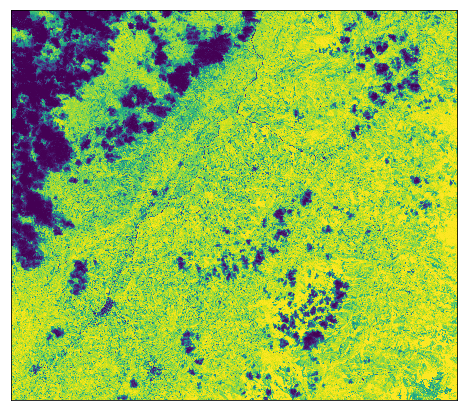

In [46]:
plot_band(band_data5_array, gray=False)

In [27]:

# def createProgressMonitor():
#     PWPM = jpy.get_type('com.bc.ceres.core.PrintWriterProgressMonitor')
#     JavaSystem = jpy.get_type('java.lang.System')
#     monitor = PWPM(JavaSystem.out)
#     return monitor

# incremental = False
# pm = createProgressMonitor()
# filename_out = 'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_subsetoutput3.dim'
# GPF.writeProduct(product_subset , 'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_subsetoutput2.dim', 'BEAM-DIMAP', incremental, pm)

In [ ]:
inFolder=‘F:/seo_dwarf/validation/platforms/OlandOst/images/sentinel_2/TOA/’
for file in os.listdir(inFolder):
path=str(inFolder+file)
print path

if path.rfind(‘S2B_MSIL1C’)!=-1 or path.rfind(‘S2A_MSIL1C’)!=-1 :
print (‘Reading image:’)
print (‘Applying atmoshphheric correction with sen2cor’)
print os.getcwd()
cmd = ‘Sen2Cor-02.05.05-win64\L2A_Process ‘+path+’ --resolution=60’
subprocess.call(cmd, shell=True)

In [29]:
ls "../../../../Desktop/"

 El volumen de la unidad C es Windows
 El n£mero de serie del volumen es: CAD2-CEC1

 Directorio de C:\Users\camil\Desktop

20/04/2021  08:47 p.ÿm.    <DIR>          .
20/04/2021  08:47 p.ÿm.    <DIR>          ..
18/04/2021  09:25 p.ÿm.             1.287 Julia 1.6.0.lnk
11/04/2021  12:39 a.ÿm.             2.363 Microsoft Teams.lnk
11/04/2021  03:58 p.ÿm.    <DIR>          Output Product.data
11/04/2021  03:53 p.ÿm.        27.630.547 Output Product.dim
11/04/2021  09:26 p.ÿm.    <DIR>          Output Product_resampled.data
11/04/2021  09:07 p.ÿm.        27.581.660 Output Product_resampled.dim
20/04/2021  08:16 p.ÿm.        40.583.356 snappy_subset_output2_geometry_1_Mask.txt
20/04/2021  09:14 p.ÿm.       283.670.916 snappy_subset_output2_geometry_1_Mask2.txt
16/04/2021  12:43 a.ÿm.    <DIR>          subset_1_of_S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105.data
16/04/2021  12:43 a.ÿm.        27.647.494 subset_1_of_S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T1531

In [8]:
import pandas as pd

In [30]:
df = pd.read_csv('../../../../Desktop/snappy_subset_output2_geometry_1_Mask2.txt', skiprows=6, sep='\t')
print(df.shape)
df

(747683, 47)


Pixel-X  Pixel-Y  Longitude  Latitude      B1      B2      B3      B4  \
0        1023.5    963.5 -73.607815  6.113812  0.1247  0.1069  0.1084  0.0895   
1        1022.5    964.5 -73.607905  6.113722  0.1247  0.1014  0.1039  0.0780   
2        1023.5    964.5 -73.607815  6.113722  0.1247  0.1034  0.1084  0.0873   
3        1021.5    965.5 -73.607996  6.113632  0.1247  0.1004  0.1091  0.0751   
4        1022.5    965.5 -73.607906  6.113631  0.1247  0.1010  0.1060  0.0772   
5        1023.5    965.5 -73.607815  6.113631  0.1247  0.1027  0.1095  0.0869   
6        1020.5    966.5 -73.608087  6.113542  0.1179  0.0991  0.1043  0.0731   
7        1021.5    966.5 -73.607996  6.113541  0.1179  0.0966  0.0977  0.0677   
8        1022.5    966.5 -73.607906  6.113541  0.1179  0.0958  0.0961  0.0643   
9        1023.5    966.5 -73.607816  6.113541  0.1179  0.0967  0.0984  0.0726   
10       1019.5    967.5 -73.608177  6.113451  0.1179  0.0956  0.0926  0.0634   
11       1020.5    967.5 -73.608087  6.113451  0.1179  0.0966  0.0861  0.0572   
12       1021.5    967.5 -73.607997  6.113451  0.1179  0.0916  0.0805  0.0532   
13       1022.5    967.5 -73.607906  6.113451  0.1179  0.0882  0.0783  0.0536   
14       1023.5    967.5 -73.607816  6.113450  0.1179  0.0884  0.0799  0.0541   
15       1018.5    968.5 -73.608268  6.113361  0.1179  0.1025  0.0930  0.0638   
16       1019.5    968.5 -73.608177  6.113361  0.1179  0.0970  0.0857  0.0547   
17       1020.5    968.5 -73.608087  6.113361  0.1179  0.0982  0.0859  0.0549   
18       1021.5    968.5 -73.607997  6.113360  0.1179  0.0967  0.0801  0.0513   
19       1022.5    968.5 -73.607906  6.113360  0.1179  0.0906  0.0773  0.0525   
20       1023.5    968.5 -73.607816  6.113360  0.1179  0.0886  0.0783  0.0511   
21       1017.5    969.5 -73.608358  6.113271  0.1252  0.1016  0.1050  0.0770   
22       1018.5    969.5 -73.608268  6.113271  0.1179  0.0996  0.0969  0.0657   
23       1019.5    969.5 -73.608178  6.113270  0.1179  0.0981  0.0897  0.0606   
24       1020.5    969.5 -73.608087  6.113270  0.1179  0.0935  0.0858  0.0623   
25       1021.5    969.5 -73.607997  6.113270  0.1179  0.0925  0.0835  0.0583   
26       1022.5    969.5 -73.607907  6.113270  0.1179  0.0916  0.0820  0.0528   
27       1023.5    969.5 -73.607816  6.113270  0.1179  0.0907  0.0799  0.0527   
28       1017.5    970.5 -73.608359  6.113180  0.1252  0.0937  0.0907  0.0652   
29       1018.5    970.5 -73.608268  6.113180  0.1179  0.0905  0.0868  0.0610   
...         ...      ...        ...       ...     ...     ...     ...     ...   
747653    994.5   3071.5 -73.610919  5.923179  0.1034  0.0888  0.0876  0.0725   
747654    995.5   3071.5 -73.610829  5.923179  0.1034  0.0897  0.0898  0.0747   
747655    996.5   3071.5 -73.610739  5.923179  0.1034  0.0886  0.0889  0.0763   
747656    997.5   3071.5 -73.610648  5.923178  0.1034  0.0874  0.0852  0.0730   
747657    998.5   3071.5 -73.610558  5.923178  0.1034  0.0843  0.0812  0.0695   
747658    999.5   3071.5 -73.610468  5.923178  0.1034  0.0839  0.0812  0.0630   
747659   1000.5   3071.5 -73.610377  5.923178  0.1028  0.0816  0.0768  0.0576   
747660   1001.5   3071.5 -73.610287  5.923177  0.1028  0.0820  0.0782  0.0605   
747661   1002.5   3071.5 -73.610197  5.923177  0.1028  0.0825  0.0802  0.0641   
747662   1003.5   3071.5 -73.610106  5.923177  0.1028  0.0830  0.0792  0.0614   
747663   1004.5   3071.5 -73.610016  5.923177  0.1028  0.0813  0.0766  0.0577   
747664   1005.5   3071.5 -73.609926  5.923177  0.1028  0.0813  0.0757  0.0573   
747665   1006.5   3071.5 -73.609835  5.923176  0.1047  0.0813  0.0771  0.0570   
747666   1007.5   3071.5 -73.609745  5.923176  0.1047  0.0825  0.0817  0.0585   
747667   1008.5   3071.5 -73.609655  5.923176  0.1047  0.0838  0.0780  0.0592   
747668   1009.5   3071.5 -73.609565  5.923176  0.1047  0.0816  0.0751  0.0614   
747669   1010.5   3071.5 -73.609474  5.923175  0.1047  0.0779  0.0692  0.0572   
747670   1011.5   3071.5 -73.609384  5.

In [31]:
df.to_csv('pixel_values_sentinel2a_image2.csv', index=False)